In [90]:
from imp import reload
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk,re,pprint
import sys,glob,os
import operator, string, argparse, math, random
import matplotlib.pyplot as plot

In [2]:
class flingPretrained:
    def __init__(self,data):
        self.data = data
        self.nDocs = len(self.data)
        self.allDistances = {}
        self.wordVecModel = None
        print("\nDBSCAN initialized!\n")
        
    def loadPretrainedWordVectors(self,vecType):
        if vecType == 'glove':
            self.wordVecModel = self.loadGloveModel()
            print("GloVe Vectors Loaded!\n")

    def loadGloveModel(self):
        print("Loading Glove Model\n")
        f = open('../datasets/glove.6B/glove.6B.50d.txt','r')
        gloveModel = {}
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            gloveModel[word] = wordEmbedding
        print(len(gloveModel)," words loaded!\n")
        return gloveModel
    
    def getDocVector(self,doc_Id):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    def addDocumentGloveVector(self):
        vecL = []
        for indx in range(self.nDocs):
            listWords_1 = set(list(self.data['tfMatrix'][int(indx)]['word']))
            gvl=self.getGloveVectorList(listWords_1)
            vecL.append(np.mean(gvl,axis=0))
        self.data['glove-vector'] = vecL

    # distance between two documents using TF-IDF
    def distanceBtnTwoDocs(self, docId_1, docId_2):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        common = listWords_1.intersection(listWords_2)
        diff1_2 = listWords_1.difference(listWords_2)
        diff2_1 = listWords_2.difference(listWords_1)
        sumwt1 = self.data['sumTFIDF'][docId_1]
        sumwt2 = self.data['sumTFIDF'][docId_2]
        score_common, score_doc1, score_doc2 = 0,0,0
        #print(len(common),len(diff1_2),len(diff2_1))
        for word_c in common:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_c]['tf-idf'])
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_c]['tf-idf'])
            score_common += abs(score_1/float(sumwt1) - score_2/float(sumwt2))
        for word_d12 in diff1_2:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_d12]['tf-idf'])
            score_doc1 += score_1/float(sumwt1)
        for word_d21 in diff2_1:
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_d21]['tf-idf'])
            score_doc2 += score_2/float(sumwt2)
        score_total = score_common + score_doc1 + score_doc2
        return(score_total)
    
    def getGloveVectorList(self,listx):
        vecList = []
        nf = []
        for w in listx:
            try:
                vecList.append(self.wordVecModel[w])
            except:
                nf.append(w)
                #print(w,"not found in glove model!")
                continue        
        if len(vecList)==0:
            return([[0]*50])
        vecArray = np.stack(vecList, axis=0 )
        return vecArray
    
    def getDocVector(self,listx):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    def getGloveDistance(self,docId_1,docId_2,method):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        if method == 'average':
            dv_1 = self.getDocVector(listWords_1)
            dv_2 = self.getDocVector(listWords_2)
            #print("dv_1",dv_1)
            #print("dv_2",dv_2)
            dist = np.linalg.norm(dv_1-dv_2)
            return dist
              
    def drawProgressBar(self, percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()	

    #sample distance between n random documents 
    def getDistanceDistribution(self,numx,method):
        numHalf = int(numx/2)
        doca,docb = [],[]
        for i in range(numHalf):
            doca.append(random.randint(1,1026))
            docb.append(random.randint(1027,2053))
        distanceSample = []
        total = numHalf*numHalf
        for doc_1 in range(len(doca)):
            for doc_2 in range(len(docb)):
                if method == 'glove':
                    distanceSample.append(self.getGloveDistance(doca[doc_1],docb[doc_2],'average'))
                else:
                    distanceSample.append(self.getGloveDistance(doca[doc_1],docb[doc_2],'average'))
                cov = doc_1*numHalf + doc_2
                prog=(cov+1)/total
                self.drawProgressBar(prog)
        pltx = plot.hist(distanceSample,bins=20)
        return(pltx)
    
    def doctfidf2vec(self,docId,mode):
        listWords = list(self.data['tfMatrix'][int(docId)]['word'])
        if mode == "tf-only":
            scores = list(self.data['tfMatrix'][int(docId)]['tf'])
        elif mode == "tf-idf":
            scores = list(self.data['tfMatrix'][int(docId)]['tf-idf'])
        lenW =len(listWords)
        vecList = []
        for w in range(lenW):
            xword = listWords[w]
            xscore = scores[w]
            try:
                vecList.append(xscore*self.wordVecModel[xword])
            except:
                continue
        if len(vecList)==0:
            return([[0]*50])
        vecArray = np.stack(vecList, axis=0)
        return(np.mean(vecArray,axis=0))
    
    def tfidf2vec(self,mode):
        vecL = []
        if mode == 'tf-only':
            columnName = 'tfidf2vec-tf'
            for indx in range(self.nDocs):
                gvl=self.doctfidf2vec(indx,'tf-only')
                vecL.append(gvl)
        else:
            columnName = 'tfidf2vec-tfidf'
            for indx in range(self.nDocs):
                gvl=self.doctfidf2vec(indx,'tf-idf')
                vecL.append(gvl)            
        self.data[columnName] = vecL

In [3]:
dataProcessed = pd.read_pickle('../processFiles/data_tfidf_processed.pkl')
fdb = flingPretrained(dataProcessed)
fdb.loadPretrainedWordVectors('glove')
fdb.addDocumentGloveVector()


DBSCAN initialized!

Loading Glove Model

400000  words loaded!

GloVe Vectors Loaded!



In [4]:
fdb.tfidf2vec('tf-only')
fdb.tfidf2vec('tf-idf')

In [5]:
fdb.data

,Job Description,Company Name,Industry,stopsRemoved,tfMatrix,sumTFIDF,glove-vector,tfidf2vec-tf,tfidf2vec-tfidf
0,Are you eager to roll up your sleeves and harn...,Vera Institute of Justice\n3.2,Social Assistance,eager roll sleeves harness data drive policy c...,word tf tf-idf 0 data...,811.569328,"[0.20507256798029555, 0.05984949950738917, 0.0...","[0.2986073091133004, 0.05040200935960588, 0.09...","[0.26263354824176166, -0.023444644206149418, -..."
1,Overview\n\nProvides analytical and technical ...,Visiting Nurse Service of New York\n3.8,Health Care Services & Hospitals,overview provides analytical technical support...,word tf tf-idf 0 dat...,415.287583,"[0.23643422682926823, -0.055056957317073156, 0...","[0.4055475764227641, -0.07285501829268287, 0.1...","[0.35240058786555273, -0.1412004425681622, 0.0..."
2,Weâre looking for a Senior Data Analyst who ...,Squarespace\n3.4,Internet,weâre looking senior data analyst love mento...,word tf tf-idf 0 data ...,439.815932,"[0.1558613515769231, 0.1173542546153846, -0.05...","[0.283220747730769, 0.14354892653846157, 0.044...","[0.2563749918506738, 0.17575736117618113, -0.0..."
3,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,Celerity\n4.1,IT Services,requisition numberrr remoteyes collaborate cre...,word tf tf-idf 0 â¢ ...,569.217931,"[0.2306739880813954, 0.09347254534883717, -0.0...","[0.29634610203488354, 0.10983982558139535, 0.0...","[0.2966705423736133, 0.028126685382837024, -0...."
4,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,FanDuel\n3.9,Sports & Recreation,fanduel group fanduel group worldclass team br...,word tf tf-idf 0 fanduel...,420.106719,"[0.12914707201834866, 0.11582829587155968, 0.0...","[0.17368260871559627, 0.10919291513761473, 0.0...","[0.021771101166884813, 0.16355587986765768, -0..."
...,...,...,...,...,...,...,...,...,...
2248,Maintains systems to protect data from unautho...,"Avacend, Inc.\n2.5",Staffing & Outsourcing,maintains systems protect data unauthorized us...,word tf tf-idf 0 ...,43.940807,"[0.27380813157894734, -0.0012553210526315914, ...","[0.2949110263157894, 0.029555310526315794, 0.0...","[0.23112386279259817, -0.08318866123802247, -0..."
2249,Position:\nSenior Data Analyst (Corporate Audi...,Arrow Electronics\n2.9,Wholesale,position senior data analyst corporate audit j...,word tf tf-idf 0 ...,439.042957,"[0.22004683554817278, 0.1071070667774087, 0.04...","[0.3396034966777404, 0.09931764750830561, 0.09...","[0.3077493047461843, 0.06387599003189207, 0.06..."
2250,"Title: Technical Business Analyst (SQL, Data a...",Spiceorb,-1,title technical business analyst sql data anal...,word tf tf-idf 0 busin...,205.978695,"[0.3618827105263159, 0.054009150657894765, 0.0...","[0.5060029144736842, 0.04490494473684211, 0.11...","[0.45506833532863533, 5.3025424212786644e-05, ..."
2251,Summary\n\nResponsible for working cross-funct...,Contingent Network Services\n3.1,Enterprise Software & Network Solutions,summary responsible working crossfunctionally ...,word tf tf-idf 0 ...,364.177527,"[0.2524797461818183, 0.07676844581818178, -0.0...","[0.34654995709090924, 0.07137524545454547, 0.0...","[0.27937433353352015, 0.08437047685035409, -0...."


[ ================================================== ] 100.00%

(array([ 15.,  66., 166., 293., 341., 400., 324., 233., 192., 138., 106.,
         84.,  56.,  17.,  27.,  31.,   7.,   1.,   2.,   1.]),
 array([0.27089853, 0.34252419, 0.41414985, 0.48577551, 0.55740117,
        0.62902683, 0.70065249, 0.77227815, 0.84390381, 0.91552947,
        0.98715513, 1.05878079, 1.13040645, 1.20203211, 1.27365777,
        1.34528343, 1.41690909, 1.48853475, 1.56016041, 1.63178607,
        1.70341173]),
 <BarContainer object of 20 artists>)

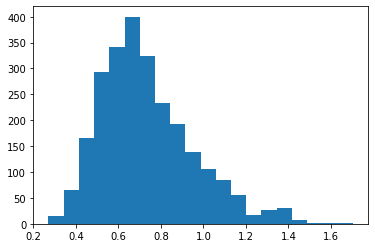

In [6]:
fdb.getDistanceDistribution(100)

[ ================================================== ] 100.00%

(array([2.000e+00, 0.000e+00, 1.000e+00, 3.300e+01, 3.050e+02, 9.910e+02,
        1.493e+03, 1.854e+03, 1.826e+03, 1.305e+03, 8.280e+02, 5.360e+02,
        3.530e+02, 2.300e+02, 1.050e+02, 9.400e+01, 2.800e+01, 9.000e+00,
        5.000e+00, 2.000e+00]),
 array([0.        , 0.08687701, 0.17375402, 0.26063102, 0.34750803,
        0.43438504, 0.52126205, 0.60813906, 0.69501606, 0.78189307,
        0.86877008, 0.95564709, 1.0425241 , 1.1294011 , 1.21627811,
        1.30315512, 1.39003213, 1.47690914, 1.56378614, 1.65066315,
        1.73754016]),
 <BarContainer object of 20 artists>)

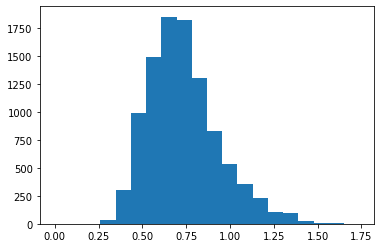

In [7]:
fdb.getDistanceDistribution(200)

In [88]:
import statistics
import matplotlib as mpl
import matplotlib.pyplot as plt

class flingDBSCAN:
    def __init__(self,data,epsilon,minPts,method):
        self.data = data
        self.method = method
        self.minPts = minPts
        self.noisePts = []
        self.nDocs = len(self.data)
        #self.clusterLabel = ['a','b','c','d','e']
        self.clusterIndex = 0 
        self.clusterCount = 0 
        print("\nflingDBSCAN initialized!\n")
        self.clusterMetadata = {}
        for i in range(self.nDocs):
            self.clusterMetadata[i] = None
        if epsilon:
            self.epsilon = epsilon
        else:
            if method == 'glove':
                self.epsilon = self.getBestDistance('glove')
                print("\nBest epsilon computed on GLOVE =",self.epsilon,"\n")
            else:
                self.epsilon = self.getBestDistance('tfidf')
                print("\nBest epsilon computed on GLOVE-TFIDF =",self.epsilon,"\n")
            
    def getBestDistance(self,method):
        numx = 100
        numHalf = int(numx/2)
        doca,docb = [],[]
        print("computing best distance")
        for i in range(numHalf):
            doca.append(random.randint(1,int(self.nDocs/2)))
            docb.append(random.randint(int(self.nDocs/2)+1,self.nDocs))
        distanceSample = []
        total = numHalf*numHalf
        for doc_1 in range(len(doca)):
            for doc_2 in range(len(docb)):
                if method == 'glove':
                    distanceSample.append(self.getDistance(doc_1,doc_2,'glove'))
                else:
                    distanceSample.append(self.getDistance(doc_1,doc_2,'tfidf'))
                cov = doc_1*numHalf + doc_2
                prog=(cov+1)/total
                self.drawProgressBar(prog)
        plt.show(plot.hist(distanceSample,bins=20))
        return statistics.mean(distanceSample)
            
    def assignLabel(self,dictDist,label):
        for el in dictDist:
            self.clusterMetadata[el]=label
            
    def printClusterInfo(self):
        print("Cluster characteristics:")
        print(" -- vectors:",self.method)
        print(" -- minPts:",self.minPts)
        print(" -- EstimatedBestDistance",self.epsilon)
        print(" --",self.clusterCount,"clusters formed!")
        print(" --",self.nDocs-len(self.noisePts),"points assigned to clusters!") 
        print(" --",len(self.noisePts),"noise points!\n")
        noisePc = len(self.noisePts)/self.nDocs*100
        print(" --",noisePc,"% noise!\n")
            
    def printClusterMetadata(self,n):
        for j in range(n):
            print(j, self.clusterMetadata[j])
         
    # range query equivalent function
    def findNeighborOf(self,ptIndex,method):
        distance = {}
        
        #first vector
        if method == 'glove':
            dv_1 = self.data['glove-vector'][int(ptIndex)] 
        elif method == 'tfidf':
            dv_1 = self.data['tfidf2vec-tfidf'][int(ptIndex)]
        
        #iterating over the whole data for the second vector 
        if method == 'tfidf':
            for j in range(self.nDocs):
                dv_2 = self.data['tfidf2vec-tfidf'][j]
                if j!=ptIndex:
                    distx = self.getDistance(ptIndex,j,'tfidf')
                    distance[j] = distx
        elif method == 'glove':
            for j in range(self.nDocs):
                dv_2 = self.data['tfidf2vec-tfidf'][j]
                if j!=ptIndex:
                    distx = self.getDistance(ptIndex,j,'glove')
                    distance[j] = distx
        
        # keeping only elements at a distnce of less than epsilon
        tempDistances = {key:value for (key,value) in distance.items() if value<self.epsilon}
        newDistances = {key:value for (key,value) in tempDistances.items() if self.clusterMetadata[key]==None}
        # keeping the cluster only if we 
        if len(newDistances)>self.minPts:    
            return newDistances.keys()
        else:
            return None
            
    def dbscanCompute(self):
        print("\ninitiating DBSCAN Clustering with",self.method,"vectors\n")
        self.clusterMetadata[0]='cluster_0_'
        for k in range(self.nDocs):
            if not self.clusterMetadata[k]:
                if self.method=='glove':
                    neighbors = self.findNeighborOf(k,'glove')
                else:
                    neighbors = self.findNeighborOf(k,'tfidf')
                if neighbors:
                    self.clusterCount+=1
                    clusterName = "cluster_" + str(self.clusterCount)+"_"
                    self.clusterMetadata[k] = clusterName
                    
                    # neighboring points of original point
                    for nbPoint in neighbors:
                        if not self.clusterMetadata[nbPoint]:
                            self.clusterMetadata[nbPoint] = clusterName
                    if self.method=='glove':
                        innerNeighbors = self.findNeighborOf(k,'glove')
                    else:
                        innerNeighbors = self.findNeighborOf(k,'tfidf')
                    if innerNeighbors:
                        for nb in innerNeighbors:
                            self.clusterMetadata[nb] = clusterName
                            neighbors.append(nb)                          
                    print("\n ---- ",clusterName,"assigned to",len(neighbors),"points! ----")
                else:
                    self.noisePts.append(k)
            prog=(k+1)/self.nDocs
            self.drawProgressBar(prog)
        print("\n",self.clusterCount,"clusters formed!")

            
    def getDistance(self,docId_1,docId_2,method):
        if method == 'glove':
            dv_1 = self.data['glove-vector'][int(docId_1)]
            dv_2 = self.data['glove-vector'][int(docId_2)]
        elif method == 'tfidf':
            dv_1 = self.data['tfidf2vec-tfidf'][int(docId_1)]
            dv_2 = self.data['tfidf2vec-tfidf'][int(docId_2)]           
        dist = np.linalg.norm(dv_1-dv_2)
        return dist
    
    def addClusterLabel(self,label):
        vec = []
        for el in self.clusterMetadata.keys():
            vec.append(el)
        self.data[label] = vec    
        
    def drawProgressBar(self, percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()	


flingDBSCAN initialized!

computing best distance
[ ================================================== ] 100.00%

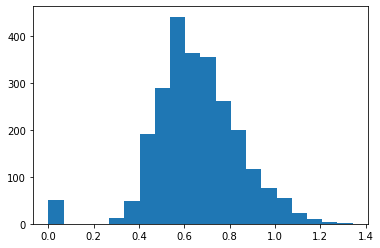


Best epsilon computed on GLOVE = 0.6544420699360174 


flingDBSCAN initialized!

computing best distance
[ ================================================== ] 100.00%

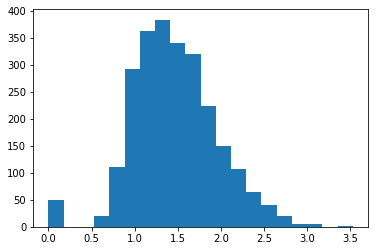


Best epsilon computed on GLOVE-TFIDF = 1.4628292329952732 


initiating DBSCAN Clustering with glove vectors

[                                                    ] 0.04%
 ----  cluster_1_ assigned to 565 points! ----
[                                                    ] 0.09%
 ----  cluster_2_ assigned to 855 points! ----
[                                                    ] 0.18%
 ----  cluster_3_ assigned to 58 points! ----
[                                                    ] 0.31%
 ----  cluster_4_ assigned to 119 points! ----
[                                                    ] 0.53%
 ----  cluster_5_ assigned to 109 points! ----
[                                                    ] 1.07%
 ----  cluster_6_ assigned to 53 points! ----
[                                                    ] 1.91%
 ----  cluster_7_ assigned to 37 points! ----
[ =                                                  ] 2.26%
 ----  cluster_8_ assigned to 55 points! ----
[ ===                        

In [91]:
fdbscan1 = flingDBSCAN(fdb.data,None,25,'glove')
fdbscan2 = flingDBSCAN(fdb.data,None,25,'tfidf')

fdbscan1.dbscanCompute()
fdbscan1.addClusterLabel('glove-clusterID')

fdbscan2.dbscanCompute()
fdbscan2.addClusterLabel('tfidf-clusterID')

fdbscan1.printClusterInfo()
fdbscan2.printClusterInfo()

Cluster characteristics:
 -- vectors: glove
 -- minPts: 25
 -- EstimatedBestDistance 0.6544420699360174
 -- 11 clusters formed!
 -- 1945 points assigned to clusters!
 -- 308 noise points!

Cluster characteristics:
 -- vectors: tfidf
 -- minPts: 25
 -- EstimatedBestDistance 1.4628292329952732
 -- 7 clusters formed!
 -- 1995 points assigned to clusters!
 -- 258 noise points!



In [50]:
fdbscan7 = flingDBSCAN(fdb.data,0.6,25)
fdbscan7.dbscanCompute('glove',None) #'dbscanGloveClusterID'


flingDBSCAN initialized!

[                                                    ] 0.04%
 ----  cluster_1_ assigned to 268 points! ----
[                                                    ] 0.09%
 ----  cluster_2_ assigned to 732 points! ----
[                                                    ] 0.18%
 ----  cluster_3_ assigned to 71 points! ----
[                                                    ] 0.22%
 ----  cluster_4_ assigned to 269 points! ----
[                                                    ] 0.31%
 ----  cluster_5_ assigned to 40 points! ----
[                                                    ] 0.53%
 ----  cluster_6_ assigned to 118 points! ----
[                                                    ] 2.00%
 ----  cluster_7_ assigned to 132 points! ----
[ =                                                  ] 2.26%
 ----  cluster_8_ assigned to 26 points! ----
[ =                                                  ] 2.93%
 ----  cluster_9_ assigned to 38 points! ----
[ == 